In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('Assignment1_2020.xlsx', header = [0,1])[:12]
data

Unnamed: 0_level_0                 Single70                            \
               Months Sales\nForecast\n(Units) Production\nCost ($/unit)   
0                 Jan                  25000.0                     450.0   
1                 Feb                  25000.0                     450.0   
2                 Mar                  26000.0                     450.0   
3                 Apr                  26000.0                     475.0   
4                 May                  27000.0                     475.0   
5                 Jun                  27000.0                     475.0   
6                 Jul                  28000.0                     500.0   
7                 Aug                  29000.0                     500.0   
8                 Sep                  30000.0                     500.0   
9                 Oct                  30000.0                     400.0   
10                Nov                  30000.0                     400.0   
11                Dec                  30000.0                     400.0   

                   Double70                            \
   Sales\nForecast\n(Units) Production\nCost ($/unit)   
0                   18500.0                     650.0   
1                   19000.0                     650.0   
2                   20000.0                     650.0   
3                   21000.0                     625.0   
4                   20000.0                     600.0   
5                   19000.0                     590.0   
6                   18000.0                     580.0   
7                   17000.0                     550.0   
8                   19000.0                     550.0   
9                   20000.0                     550.0   
10                  20500.0                     610.0   
11                  21000.0                     640.0   

                   Double80                            
   Sales\nForecast\n(Units) Production\nCost ($/unit)  
0                    9500.0                     810.0  
1                    9500.0                     810.0  
2                    9500.0                     880.0  
3                    7500.0                     880.0  
4                    7500.0                     880.0  
5                    7500.0                     880.0  
6                    6500.0                     880.0  
7                    6500.0                     840.0  
8                    6500.0                     840.0  
9                    6500.0                     840.0  
10                   6500.0                     880.0  
11                   6500.0                     880.0

In [3]:
data['Double70']['Sales\nForecast\n(Units)']

0     18500.0
1     19000.0
2     20000.0
3     21000.0
4     20000.0
5     19000.0
6     18000.0
7     17000.0
8     19000.0
9     20000.0
10    20500.0
11    21000.0
Name: Sales\nForecast\n(Units), dtype: float64

In [4]:
#Constant Workforce
#Overtime Allowed
#Shortages Not Allowed

inv_carry_rate = np.r_[[0.01]*6, [0.013]*6]
prod_times = {'Single70': 1.65, 'Double70': 2.15, 'Double80': 2.68}
reg_workforce = np.r_[[90000]*6, [100000]*6]
overtime_workforce = reg_workforce*0.25
reg_cost = np.r_[[30]*6, [35]*6]
overtime_cost = reg_cost*1.5
I0 =[6500, 12000, 3000]


In [5]:
V = np.c_[data['Single70']['Production\nCost ($/unit)'], data['Double70']['Production\nCost ($/unit)'],data['Double80']['Production\nCost ($/unit)']].T
C = np.multiply(V , inv_carry_rate)
d = np.c_[data['Single70']['Sales\nForecast\n(Units)'], data['Double70']['Sales\nForecast\n(Units)'],data['Double80']['Sales\nForecast\n(Units)']].T
k = np.array(list(prod_times.values()))

## Base Model

In [6]:
import pyomo.environ as pyo
i = 3
t = 12
M_Base = pyo.ConcreteModel()
M_Base.i = range(i)
M_Base.t = range(t)
M_Base.t2 = range(1,t)

M_Base.X = pyo.Var(M_Base.i, M_Base.t, domain = pyo.NonNegativeReals)
M_Base.W = pyo.Var(M_Base.t, domain = pyo.NonNegativeReals)
M_Base.O = pyo.Var(M_Base.t, domain = pyo.NonNegativeReals)
M_Base.I = pyo.Var(M_Base.i, M_Base.t, domain = pyo.NonNegativeReals)

def obj(model):
    return sum(C[i,t]*model.I[i,t] for i in model.i for t in model.t) + sum(V[i,t]*model.X[i,t] for i in model.i for t in model.t) + sum(reg_cost[t]*model.W[t] for t in model.t) + sum(overtime_cost[t]*model.O[t] for t in model.t) 

M_Base.obj = pyo.Objective(rule = obj, sense= pyo.minimize)

def c0_rule(model, i):
    return model.X[i,0] + I0[i] - d[i,0] -  model.I[i,0] == 0
def c1_rule(model, i, t2):
    return model.X[i,t2] + model.I[i,t2-1] - d[i,t2] - model.I[i,t2] == 0
def c2_rule(model, t):
    return model.W[t] <= reg_workforce[t]
def c3_rule(model, t):
    return model.O[t] <= overtime_workforce[t]
def c4_rule(model, t):
    return sum(model.X[i,t]*k[i] for i in model.i) <= model.O[t] + model.W[t]

M_Base.c1 = pyo.Constraint(M_Base.i, M_Base.t2, rule = c1_rule)
M_Base.c2 = pyo.Constraint(M_Base.t, rule = c2_rule)
M_Base.c3 = pyo.Constraint(M_Base.t, rule = c3_rule)
M_Base.c4 = pyo.Constraint(M_Base.t, rule = c4_rule)
M_Base.c0 = pyo.Constraint(M_Base.i, rule = c0_rule)

In [7]:
opt = pyo.SolverFactory('mosek')
opt.solve(M_Base, tee = True)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 72              
  Cones                  : 0               
  Scalar variables       : 96              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

{'Problem': [{'Name': '', 'Lower bound': 395706458.6950624, 'Upper bound': 395706458.8416533, 'Number of objectives': 1, 'Number of constraints': 72, 'Number of variables': 96, 'Number of integer variables': 0, 'Number of continuous variables': 96, 'Number of nonzeros': 189, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Mosek 9.1.9', 'Status': 'ok', 'Wallclock time': 0.079, 'Termination condition': 'optimal', 'Termination message': ' Model was solved to optimality, and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [8]:
def get_results(M):
    X = []
    [X.append(M.X[i,t]()) for i in M.i for t in M.t]
    X =np.reshape(X, (i,t))
    X_df = pd.DataFrame(X.T, columns = list(prod_times.keys()))
    
    I = []
    [I.append(M.I[i,t]()) for i in M.i for t in M.t]
    I =np.reshape(I, (i,t))
    I_df = pd.DataFrame(I.T, columns = list(prod_times.keys()))

    O = []
    [O.append(M.O[t]()) for t in M.t]
    O =np.array(O)
    O_df = pd.DataFrame(O.T, columns = ['Value'])
    
    W = []
    [W.append(M.W[t]()) for t in M.t]
    W =np.array(W)
    W_df = pd.DataFrame(W.T, columns = ['Value'])
    
    return {'X':X_df, 'I':I_df, 'O':O_df, 'W':W_df, 'Objective': M.obj()}
    

In [9]:
base = get_results(M_Base)
base['Objective']

395706458.8416532

## Extention I

In [10]:
bigM = 1000
extra_worker_cost = [bigM]*5 + [38]*3 + [bigM]*4

M_Ext1= pyo.ConcreteModel()
M_Ext1.i = range(i)
M_Ext1.t = range(t)
M_Ext1.t2 = range(1,t)

M_Ext1.E = pyo.Var(M_Ext1.t, domain = pyo.NonNegativeReals)

def obj_ext1(model):
    return sum(C[i,t]*model.I[i,t] for i in model.i for t in model.t) + sum(V[i,t]*model.X[i,t] for i in model.i for t in model.t) + sum(reg_cost[t]*model.W[t] for t in model.t) + sum(overtime_cost[t]*model.O[t] for t in model.t) + sum(extra_worker_cost[t]*model.E[t] for t in model.t)

In [11]:
i = 3
t = 12

M_Ext1.X = pyo.Var(M_Ext1.i, M_Ext1.t, domain = pyo.NonNegativeReals)
M_Ext1.W = pyo.Var(M_Ext1.t, domain = pyo.NonNegativeReals)
M_Ext1.O = pyo.Var(M_Ext1.t, domain = pyo.NonNegativeReals)
M_Ext1.I = pyo.Var(M_Ext1.i, M_Ext1.t, domain = pyo.NonNegativeReals)


M_Ext1.obj = pyo.Objective(rule = obj_ext1, sense= pyo.minimize)

def c0_rule(model, i):
    return model.X[i,0] + I0[i] - d[i,0] -  model.I[i,0] == 0
def c1_rule(model, i, t2):
    return model.X[i,t2] + model.I[i,t2-1] - d[i,t2] - model.I[i,t2] == 0
def c2_rule(model, t):
    return model.W[t] <= reg_workforce[t]
def c3_rule(model, t):
    return model.O[t] <= overtime_workforce[t]
def c4_rule(model, t):
    return sum(model.X[i,t]*k[i] for i in model.i) <= model.O[t] + model.W[t] + model.E[t]

M_Ext1.c1 = pyo.Constraint(M_Ext1.i, M_Ext1.t2, rule = c1_rule)
M_Ext1.c2 = pyo.Constraint(M_Ext1.t, rule = c2_rule)
M_Ext1.c3 = pyo.Constraint(M_Ext1.t, rule = c3_rule)
M_Ext1.c4 = pyo.Constraint(M_Ext1.t, rule = c4_rule)
M_Ext1.c0 = pyo.Constraint(M_Ext1.i, rule = c0_rule)

In [12]:
opt.solve(M_Ext1, tee = True)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 72              
  Cones                  : 0               
  Scalar variables       : 108             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

{'Problem': [{'Name': '', 'Lower bound': 394054275.479127, 'Upper bound': 394054275.5735067, 'Number of objectives': 1, 'Number of constraints': 72, 'Number of variables': 108, 'Number of integer variables': 0, 'Number of continuous variables': 108, 'Number of nonzeros': 201, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Mosek 9.1.9', 'Status': 'ok', 'Wallclock time': 0.062, 'Termination condition': 'optimal', 'Termination message': ' Model was solved to optimality, and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [13]:
ext1 = get_results(M_Ext1)
ext1['Objective']

394054275.57350665

In [14]:
ext1['I']

,Single70,Double70,Double80
0,25000.000000,0.000000,3481.343284
1,0.000000,0.000000,20716.417910
2,3478.787879,0.000000,11216.417910
3,4660.606061,0.000000,3716.417910
4,0.000000,0.000000,0.000000
5,87000.000000,0.000000,0.000000
6,59000.000000,0.000000,0.000000
7,30000.000000,34806.976744,0.000000
8,0.000000,54216.279070,0.000000
9,0.000000,41500.000000,6500.000000


In [15]:
ext1['X']

,Single70,Double70,Double80
0,43500.000000,6500.000000,9981.343284
1,0.000000,19000.000000,26735.074627
2,29478.787879,20000.000000,0.000000
3,27181.818182,21000.000000,0.000000
4,22339.393939,20000.000000,3783.582090
5,114000.000000,19000.000000,7500.000000
6,0.000000,18000.000000,6500.000000
7,0.000000,51806.976744,6500.000000
8,0.000000,38409.302326,6500.000000
9,30000.000000,7283.720930,13000.000000


In [16]:
ext1['W']

,Value
0,90000.0
1,90000.0
2,90000.0
3,90000.0
4,90000.0
5,90000.0
6,56120.0
7,100000.0
8,100000.0
9,100000.0


In [17]:
ext1['O']

,Value
0,22500.0
1,22500.0
2,1640.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [18]:
E = []
[E.append(M_Ext1.E[t]()) for t in M_Ext1.t]
E =np.array(E)
E_df = pd.DataFrame(E.T, columns = ['Value'])
ext1['E'] = E_df
ext1['E']

,Value
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,159050.0
6,0.0
7,28805.0
8,0.0
9,0.0


## Extention 2

In [19]:
max_inv = 25000

In [20]:
M_Ext2 = pyo.ConcreteModel()
M_Ext2.i = range(i)
M_Ext2.t = range(t)
M_Ext2.t2 = range(1,t)

M_Ext2.X = pyo.Var(M_Ext2.i, M_Ext2.t, domain = pyo.NonNegativeReals)
M_Ext2.W = pyo.Var(M_Ext2.t, domain = pyo.NonNegativeReals)
M_Ext2.O = pyo.Var(M_Ext2.t, domain = pyo.NonNegativeReals)
M_Ext2.I = pyo.Var(M_Ext2.i, M_Ext2.t, domain = pyo.NonNegativeReals)

def obj(model):
    return sum(C[i,t]*model.I[i,t] for i in model.i for t in model.t) + sum(V[i,t]*model.X[i,t] for i in model.i for t in model.t) + sum(reg_cost[t]*model.W[t] for t in model.t) + sum(overtime_cost[t]*model.O[t] for t in model.t) 

M_Ext2.obj = pyo.Objective(rule = obj, sense= pyo.minimize)

def c0_rule(model, i):
    return model.X[i,0] + I0[i] - d[i,0] -  model.I[i,0] == 0
def c1_rule(model, i, t2):
    return model.X[i,t2] + model.I[i,t2-1] - d[i,t2] - model.I[i,t2] == 0
def c2_rule(model, t):
    return model.W[t] <= reg_workforce[t]
def c3_rule(model, t):
    return model.O[t] <= overtime_workforce[t]
def c4_rule(model, t):
    return sum(model.X[i,t]*k[i] for i in model.i) <= model.O[t] + model.W[t]
def extention2_rule(model, t):
    return sum(model.I[i,t] for i in model.i ) <= max_inv

M_Ext2.c1 = pyo.Constraint(M_Ext2.i, M_Ext2.t2, rule = c1_rule)
M_Ext2.c2 = pyo.Constraint(M_Ext2.t, rule = c2_rule)
M_Ext2.c3 = pyo.Constraint(M_Ext2.t, rule = c3_rule)
M_Ext2.c4 = pyo.Constraint(M_Ext2.t, rule = c4_rule)
M_Ext2.c0 = pyo.Constraint(M_Ext2.i, rule = c0_rule)
M_Ext2.c5 = pyo.Constraint(M_Ext2.t, rule = extention2_rule)

In [21]:
opt.solve(M_Ext2, tee = True)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 84              
  Cones                  : 0               
  Scalar variables       : 96              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

{'Problem': [{'Name': '', 'Lower bound': 396131180.59997547, 'Upper bound': 396131181.21629524, 'Number of objectives': 1, 'Number of constraints': 84, 'Number of variables': 96, 'Number of integer variables': 0, 'Number of continuous variables': 96, 'Number of nonzeros': 225, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Mosek 9.1.9', 'Status': 'ok', 'Wallclock time': 0.063, 'Termination condition': 'optimal', 'Termination message': ' Model was solved to optimality, and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [22]:
ext2 = get_results(M_Ext2)
print(ext2['Objective'])
ext2['Objective'] - ext1['Objective'] 

396131181.2162952


2076905.6427885294

In [23]:
ext2['I']

,Single70,Double70,Double80
0,15941.747573,0.000000,9058.252427
1,0.000000,0.000000,20716.417910
2,13783.582090,0.000000,11216.417910
3,14965.400271,0.000000,3716.417910
4,20757.575758,0.000000,0.000000
5,25000.000000,0.000000,0.000000
6,23593.939394,0.000000,0.000000
7,0.000000,17260.465116,0.000000
8,0.000000,17986.046512,0.000000
9,0.000000,25000.000000,0.000000


## Extention 3

In [24]:
bigM = 1000
max_inv = 25000
extra_worker_cost = [bigM]*5 + [38]*3 + [bigM]*4

M_Ext3 = pyo.ConcreteModel()
M_Ext3.i = range(i)
M_Ext3.t = range(t)
M_Ext3.t2 = range(1,t)

M_Ext3.E = pyo.Var(M_Ext3.t, domain = pyo.NonNegativeReals)

def obj_ext1(model):
    return sum(C[i,t]*model.I[i,t] for i in model.i for t in model.t) + sum(V[i,t]*model.X[i,t] for i in model.i for t in model.t) + sum(reg_cost[t]*model.W[t] for t in model.t) + sum(overtime_cost[t]*model.O[t] for t in model.t) + sum(extra_worker_cost[t]*model.E[t] for t in model.t)

M_Ext3.X = pyo.Var(M_Ext3.i, M_Ext3.t, domain = pyo.NonNegativeReals)
M_Ext3.W = pyo.Var(M_Ext3.t, domain = pyo.NonNegativeReals)
M_Ext3.O = pyo.Var(M_Ext3.t, domain = pyo.NonNegativeReals)
M_Ext3.I = pyo.Var(M_Ext3.i, M_Ext3.t, domain = pyo.NonNegativeReals)


M_Ext3.obj = pyo.Objective(rule = obj_ext1, sense= pyo.minimize)

def c0_rule(model, i):
    return model.X[i,0] + I0[i] - d[i,0] -  model.I[i,0] == 0
def c1_rule(model, i, t2):
    return model.X[i,t2] + model.I[i,t2-1] - d[i,t2] - model.I[i,t2] == 0
def c2_rule(model, t):
    return model.W[t] <= reg_workforce[t]
def c3_rule(model, t):
    return model.O[t] <= overtime_workforce[t]
def c4_rule(model, t):
    return sum(model.X[i,t]*k[i] for i in model.i) <= model.O[t] + model.W[t] + model.E[t]
def extention2_rule(model, t):
    return sum(model.I[i,t] for i in model.i ) <= max_inv

M_Ext3.c1 = pyo.Constraint(M_Ext3.i, M_Ext3.t2, rule = c1_rule)
M_Ext3.c2 = pyo.Constraint(M_Ext3.t, rule = c2_rule)
M_Ext3.c3 = pyo.Constraint(M_Ext3.t, rule = c3_rule)
M_Ext3.c4 = pyo.Constraint(M_Ext3.t, rule = c4_rule)
M_Ext3.c0 = pyo.Constraint(M_Ext3.i, rule = c0_rule)
M_Ext3.c5 = pyo.Constraint(M_Ext3.t, rule = extention2_rule)

In [25]:
opt.solve(M_Ext3, tee = True)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 84              
  Cones                  : 0               
  Scalar variables       : 108             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.02    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

{'Problem': [{'Name': '', 'Lower bound': 395584496.93653136, 'Upper bound': 395584496.9365313, 'Number of objectives': 1, 'Number of constraints': 84, 'Number of variables': 108, 'Number of integer variables': 0, 'Number of continuous variables': 108, 'Number of nonzeros': 237, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Mosek 9.1.9', 'Status': 'ok', 'Wallclock time': 0.078, 'Termination condition': 'optimal', 'Termination message': ' Model was solved to optimality, and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [26]:
ext3 = get_results(M_Ext3)
print(ext3['Objective'])
ext3['Objective'] - ext2['Objective'] 

395584496.93653125


-546684.279763937

In [27]:
E = []
[E.append(M_Ext3.E[t]()) for t in M_Ext3.t]
E =np.array(E)
E_df = pd.DataFrame(E.T, columns = ['Value'])
ext3['E'] = E_df
ext3['E']

,Value
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,56750.0
6,0.0
7,62460.0
8,0.0
9,0.0


## Extention 4

In [28]:
inv_carry_rate2 = [0.01]*6 + [0.02]*6
C2 = np.multiply(V , inv_carry_rate2)

In [29]:
M_Ext4 = pyo.ConcreteModel()
M_Ext4.i = range(i)
M_Ext4.t = range(t)
M_Ext4.t2 = range(1,t)

def obj(model):
    return sum(C2[i,t]*model.I[i,t] for i in model.i for t in model.t) + sum(V[i,t]*model.X[i,t] for i in model.i for t in model.t) + sum(reg_cost[t]*model.W[t] for t in model.t) + sum(overtime_cost[t]*model.O[t] for t in model.t)

M_Ext4.X = pyo.Var(M_Ext4.i, M_Ext4.t, domain = pyo.NonNegativeReals)
M_Ext4.W = pyo.Var(M_Ext4.t, domain = pyo.NonNegativeReals)
M_Ext4.O = pyo.Var(M_Ext4.t, domain = pyo.NonNegativeReals)
M_Ext4.I = pyo.Var(M_Ext4.i, M_Ext4.t, domain = pyo.NonNegativeReals)


M_Ext4.obj = pyo.Objective(rule = obj, sense= pyo.minimize)

def c0_rule(model, i):
    return model.X[i,0] + I0[i] - d[i,0] -  model.I[i,0] == 0
def c1_rule(model, i, t2):
    return model.X[i,t2] + model.I[i,t2-1] - d[i,t2] - model.I[i,t2] == 0
def c2_rule(model, t):
    return model.W[t] <= reg_workforce[t]
def c3_rule(model, t):
    return model.O[t] <= overtime_workforce[t]
def c4_rule(model, t):
    return sum(model.X[i,t]*k[i] for i in model.i) <= model.O[t] + model.W[t]

M_Ext4.c1 = pyo.Constraint(M_Ext4.i, M_Ext4.t2, rule = c1_rule)
M_Ext4.c2 = pyo.Constraint(M_Ext4.t, rule = c2_rule)
M_Ext4.c3 = pyo.Constraint(M_Ext4.t, rule = c3_rule)
M_Ext4.c4 = pyo.Constraint(M_Ext4.t, rule = c4_rule)
M_Ext4.c0 = pyo.Constraint(M_Ext4.i, rule = c0_rule)


In [30]:
opt.solve(M_Ext4, tee = True)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 72              
  Cones                  : 0               
  Scalar variables       : 96              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

{'Problem': [{'Name': '', 'Lower bound': 396368861.50016105, 'Upper bound': 396368861.54073715, 'Number of objectives': 1, 'Number of constraints': 72, 'Number of variables': 96, 'Number of integer variables': 0, 'Number of continuous variables': 96, 'Number of nonzeros': 189, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Mosek 9.1.9', 'Status': 'ok', 'Wallclock time': 0.078, 'Termination condition': 'optimal', 'Termination message': ' Model was solved to optimality, and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [31]:
ext4 = get_results(M_Ext4)
print(ext4['Objective'])
ext4['Objective'] - base['Objective']

396368861.5407371


662402.6990838647

In [49]:
base['X'].join(ext4['X'], lsuffix='_Base', rsuffix='_Ext4')

,Single70_Base,Double70_Base,Double80_Base,Single70_Ext4,Double70_Ext4,Double80_Ext4
0,43500.000000,6500.000000,9981.343284,43500.000000,6500.000000,9981.343284
1,0.000000,19000.000000,26735.074627,0.000000,19000.000000,26735.074627
2,42121.212121,20000.000000,0.000000,42121.212121,20000.000000,0.000000
3,40818.181818,21000.000000,0.000000,40818.181818,21000.000000,0.000000
4,35975.757576,20000.000000,3783.582090,35975.757576,20000.000000,3783.582090
5,31242.424242,19000.000000,7500.000000,31242.424242,19000.000000,7500.000000
6,26593.939394,18000.000000,6500.000000,26593.939394,18000.000000,6500.000000
7,0.000000,38409.302326,6500.000000,0.000000,38409.302326,6500.000000
8,16248.484848,32076.744186,6500.000000,16248.484848,32076.744186,6500.000000
9,30000.000000,27013.953488,6500.000000,30000.000000,27013.953488,6500.000000


In [50]:
base['I'].join(ext4['I'], lsuffix='_Base', rsuffix='_Ext4')

,Single70_Base,Double70_Base,Double80_Base,Single70_Ext4,Double70_Ext4,Double80_Ext4
0,25000.000000,0.000000,3481.343284,25000.000000,0.000000,3481.343284
1,0.000000,0.000000,20716.417910,0.000000,0.000000,20716.417910
2,16121.212121,0.000000,11216.417910,16121.212121,0.000000,11216.417910
3,30939.393939,0.000000,3716.417910,30939.393939,0.000000,3716.417910
4,39915.151515,0.000000,0.000000,39915.151515,0.000000,0.000000
5,44157.575758,0.000000,0.000000,44157.575758,0.000000,0.000000
6,42751.515152,0.000000,0.000000,42751.515152,0.000000,0.000000
7,13751.515152,21409.302326,0.000000,13751.515152,21409.302326,0.000000
8,0.000000,34486.046512,0.000000,0.000000,34486.046512,0.000000
9,0.000000,41500.000000,0.000000,0.000000,41500.000000,0.000000


In [51]:
base['W'].join(ext4['W'], lsuffix='_Base', rsuffix='_Ext4')

,Value_Base,Value_Ext4
0,90000.0,90000.0
1,90000.0,90000.0
2,90000.0,90000.0
3,90000.0,90000.0
4,90000.0,90000.0
5,90000.0,90000.0
6,100000.0,100000.0
7,100000.0,100000.0
8,100000.0,100000.0
9,100000.0,100000.0


In [52]:
base['O'].join(ext4['O'], lsuffix='_Base', rsuffix='_Ext4')

,Value_Base,Value_Ext4
0,22500.0,22500.0
1,22500.0,22500.0
2,22500.0,22500.0
3,22500.0,22500.0
4,22500.0,22500.0
5,22500.0,22500.0
6,0.0,0.0
7,0.0,0.0
8,13195.0,13195.0
9,25000.0,25000.0


In [55]:
- base['Objective'] +ext4['Objective']

662402.6990838647

## Extension 5

In [32]:
def Ext5(k_rate):
    M_Ext5_1 = pyo.ConcreteModel()
    M_Ext5_1.i = range(i)
    M_Ext5_1.t = range(t)
    M_Ext5_1.t2 = range(1,t)

    M_Ext5_1.X = pyo.Var(M_Ext5_1.i, M_Ext5_1.t, domain = pyo.NonNegativeReals)
    M_Ext5_1.W = pyo.Var(M_Ext5_1.t, domain = pyo.NonNegativeReals)
    M_Ext5_1.O = pyo.Var(M_Ext5_1.t, domain = pyo.NonNegativeReals)
    M_Ext5_1.I = pyo.Var(M_Ext5_1.i, M_Ext5_1.t, domain = pyo.NonNegativeReals)

    def obj(model):
        return sum(C[i,t]*model.I[i,t] for i in model.i for t in model.t) + sum(V[i,t]*model.X[i,t] for i in model.i for t in model.t) + sum(reg_cost[t]*model.W[t] for t in model.t) + sum(overtime_cost[t]*model.O[t] for t in model.t) 

    M_Ext5_1.obj = pyo.Objective(rule = obj, sense= pyo.minimize)

    def c0_rule(model, i):
        return model.X[i,0] + I0[i] - d[i,0] -  model.I[i,0] == 0
    def c1_rule(model, i, t2):
        return model.X[i,t2] + model.I[i,t2-1] - d[i,t2] - model.I[i,t2] == 0
    def c2_rule(model, t):
        return model.W[t] <= reg_workforce[t]
    def c3_rule(model, t):
        return model.O[t] <= overtime_workforce[t]
    def c4_rule(model, t):
        return sum(model.X[i,t]*k[i]*k_rate[i] for i in model.i) <= model.O[t] + model.W[t]
    def extention2_rule(model, t):
        return sum(model.I[i,t] for i in model.i ) <= max_inv

    M_Ext5_1.c1 = pyo.Constraint(M_Ext5_1.i, M_Ext5_1.t2, rule = c1_rule)
    M_Ext5_1.c2 = pyo.Constraint(M_Ext5_1.t, rule = c2_rule)
    M_Ext5_1.c3 = pyo.Constraint(M_Ext5_1.t, rule = c3_rule)
    M_Ext5_1.c4 = pyo.Constraint(M_Ext5_1.t, rule = c4_rule)
    M_Ext5_1.c0 = pyo.Constraint(M_Ext5_1.i, rule = c0_rule)
    M_Ext5_1.c5 = pyo.Constraint(M_Ext5_1.t, rule = extention2_rule)
    
    opt.solve(M_Ext5_1, tee = False)
    ext5_1 = get_results(M_Ext5_1)
    
    return ext5_1

In [33]:
from itertools import product
ext5_res ={}
for p in product((1.1, 0.9), repeat=3):
    ext5_res[p] = Ext5(p)['Objective']
    

In [34]:
ext5_res

{(1.1, 1.1, 1.1): 403033533.0413697,
 (1.1, 1.1, 0.9): 400063669.04410243,
 (1.1, 0.9, 1.1): 397580235.4840341,
 (1.1, 0.9, 0.9): 395179298.97944695,
 (0.9, 1.1, 1.1): 397061021.6023345,
 (0.9, 1.1, 0.9): 394735107.7910892,
 (0.9, 0.9, 1.1): 392612660.6611183,
 (0.9, 0.9, 0.9): 390512284.5574223}

In [111]:
ext5 = pd.DataFrame.from_dict(ext5_res, orient='index', columns = ['Value'])
ext5['Difference'] = ext5['Value'] - ext2['Objective']
ext5

,Value,Difference
"(1.1, 1.1, 1.1)",4.030335e+08,6.902352e+06
"(1.1, 1.1, 0.9)",4.000637e+08,3.932488e+06
"(1.1, 0.9, 1.1)",3.975802e+08,1.449054e+06
"(1.1, 0.9, 0.9)",3.951793e+08,-9.518822e+05
"(0.9, 1.1, 1.1)",3.970610e+08,9.298404e+05
"(0.9, 1.1, 0.9)",3.947351e+08,-1.396073e+06
"(0.9, 0.9, 1.1)",3.926127e+08,-3.518521e+06
"(0.9, 0.9, 0.9)",3.905123e+08,-5.618897e+06


## Extention 6

In [35]:
bigM = 100000000
M_Ext6 = pyo.ConcreteModel()
M_Ext6.i = range(i)
M_Ext6.t = range(t)
M_Ext6.t2 = range(1,t)
max_inv = 25000
#update demand
d2 = d.copy()
d2[2,3] = 17500
d2[2,4] =  17500
d2[2,5] =  17500
#Shortage Variable
M_Ext6.S = pyo.Var(M_Ext6.i, M_Ext6.t, domain = pyo.NonNegativeReals)

In [36]:
d2

array([[25000., 25000., 26000., 26000., 27000., 27000., 28000., 29000.,
        30000., 30000., 30000., 30000.],
       [18500., 19000., 20000., 21000., 20000., 19000., 18000., 17000.,
        19000., 20000., 20500., 21000.],
       [ 9500.,  9500.,  9500., 17500., 17500., 17500.,  6500.,  6500.,
         6500.,  6500.,  6500.,  6500.]])

In [37]:
M_Ext6.X = pyo.Var(M_Ext6.i, M_Ext6.t, domain = pyo.NonNegativeReals)
M_Ext6.W = pyo.Var(M_Ext6.t, domain = pyo.NonNegativeReals)
M_Ext6.O = pyo.Var(M_Ext6.t, domain = pyo.NonNegativeReals)
M_Ext6.I = pyo.Var(M_Ext6.i, M_Ext6.t, domain = pyo.NonNegativeReals)

#Include bigM*S to ensure shortage is the latest choice of the model
def obj_ext6(model):
    return sum(model.S[i,t]*bigM for i in model.i for t in model.t) + sum(C[i,t]*model.I[i,t] for i in model.i for t in model.t) + sum(V[i,t]*model.X[i,t] for i in model.i for t in model.t) + sum(reg_cost[t]*model.W[t] for t in model.t) + sum(overtime_cost[t]*model.O[t] for t in model.t) 

M_Ext6.obj = pyo.Objective(rule = obj_ext6, sense= pyo.minimize) #obj_ext6, sense= pyo.minimize)

#Update demand constraints (c0, c1) to include shortages
def c0_rule(model, i):
    return model.X[i,0] + I0[i] - d2[i,0] -  model.I[i,0] + model.S[i,0] == 0
def c1_rule(model, i, t2):
    return model.X[i,t2] + model.I[i,t2-1] - d2[i,t2] - model.I[i,t2] + model.S[i,t2] == 0
def c2_rule(model, t):
    return model.W[t] <= reg_workforce[t]
def c3_rule(model, t):
    return model.O[t] <= overtime_workforce[t]
def c4_rule(model, t):
    return sum(model.X[i,t]*k[i] for i in model.i) <= model.O[t] + model.W[t]
def extention2_rule(model, t):
    return sum(model.I[i,t] for i in model.i ) <= max_inv

M_Ext6.c1 = pyo.Constraint(M_Ext6.i, M_Ext6.t2, rule = c1_rule)
M_Ext6.c2 = pyo.Constraint(M_Ext6.t, rule = c2_rule)
M_Ext6.c3 = pyo.Constraint(M_Ext6.t, rule = c3_rule)
M_Ext6.c4 = pyo.Constraint(M_Ext6.t, rule = c4_rule)
M_Ext6.c0 = pyo.Constraint(M_Ext6.i, rule = c0_rule)
M_Ext6.c5 = pyo.Constraint(M_Ext6.t, rule = extention2_rule)


In [38]:
opt.solve(M_Ext6, tee = True)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 84              
  Cones                  : 0               
  Scalar variables       : 132             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

{'Problem': [{'Name': '', 'Lower bound': 281767268904.6953, 'Upper bound': 281767268904.6935, 'Number of objectives': 1, 'Number of constraints': 84, 'Number of variables': 132, 'Number of integer variables': 0, 'Number of continuous variables': 132, 'Number of nonzeros': 261, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Mosek 9.1.9', 'Status': 'ok', 'Wallclock time': 0.047, 'Termination condition': 'optimal', 'Termination message': ' Model was solved to optimality, and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [39]:
ext6 = get_results(M_Ext6)
ext6['Objective']

281767268904.69324

In [40]:
S = []
[S.append(M_Ext6.S[i,t]()) for i in M_Ext6.i for t in M_Ext6.t]
S =np.reshape(S, (i,t))
S_df = pd.DataFrame(S.T, columns = list(prod_times.keys()))
ext6['S'] = S_df
ext6['S']

,Single70,Double70,Double80
0,-0.0,-0.0,-0.000000
1,-0.0,-0.0,-0.000000
2,-0.0,-0.0,-0.000000
3,-0.0,-0.0,-0.000000
4,-0.0,-0.0,-0.000000
5,-0.0,-0.0,2813.432836
6,-0.0,-0.0,-0.000000
7,-0.0,-0.0,-0.000000
8,-0.0,-0.0,-0.000000
9,-0.0,-0.0,-0.000000


In [41]:
ext6['I']

,Single70,Double70,Double80
0,15941.747573,0.000000,9058.252427
1,0.000000,0.000000,20716.417910
2,10038.834951,0.000000,14961.165049
3,20733.333333,0.000000,0.000000
4,7430.303030,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,9972.093023,0.000000
8,0.000000,17986.046512,0.000000
9,0.000000,25000.000000,0.000000


In [42]:
ext6['X']

,Single70,Double70,Double80
0,34441.747573,6500.000000,15558.252427
1,9058.252427,19000.000000,21158.165483
2,36038.834951,20000.000000,3744.747138
3,36694.498382,21000.000000,2538.834951
4,13696.969697,20000.000000,17500.000000
5,19569.696970,19000.000000,14686.567164
6,28000.000000,18000.000000,6500.000000
7,29000.000000,26972.093023,6500.000000
8,30000.000000,27013.953488,6500.000000
9,30000.000000,27013.953488,6500.000000


In [ ]:
M_Base.display()

In [ ]:
M_Base.pprint()

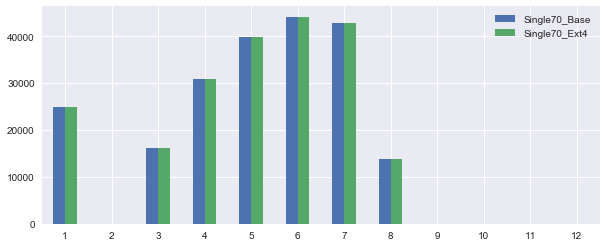

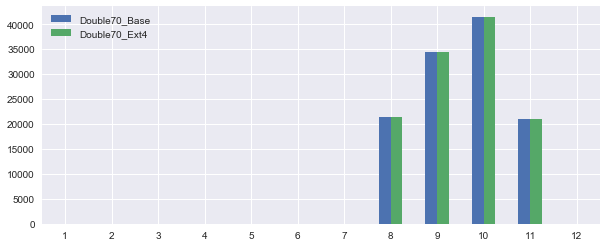

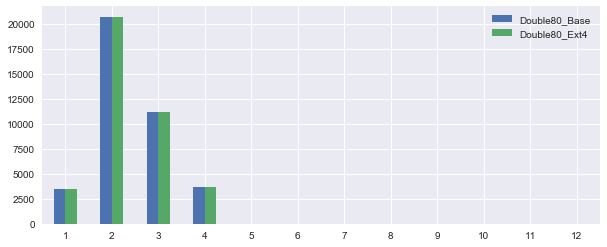

In [102]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,4))
ax = base['I'][['Single70']].join(ext4['I'][['Single70']], lsuffix='_Base', rsuffix='_Ext4').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
fig, ax = plt.subplots(figsize=(10,4))
ax = base['I'][['Double70']].join(ext4['I'][['Double70']], lsuffix='_Base', rsuffix='_Ext4').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
fig, ax = plt.subplots(figsize=(10,4))
ax = base['I'][['Double80']].join(ext4['I'][['Double80']], lsuffix='_Base', rsuffix='_Ext4').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
plt.show()

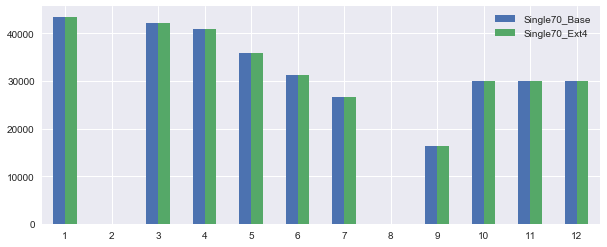

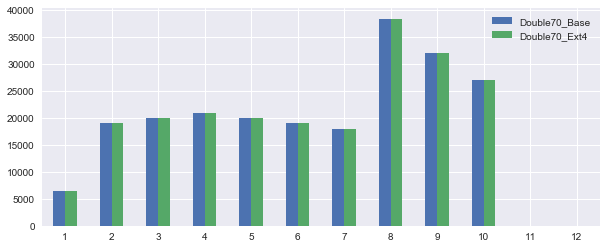

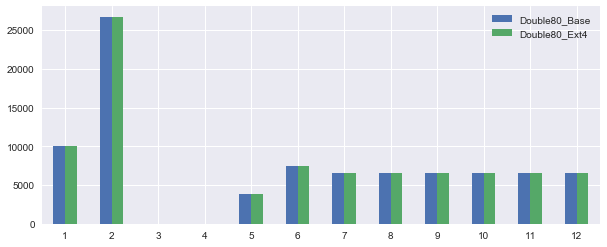

In [101]:
fig, ax = plt.subplots(figsize=(10,4))
ax = base['X'][['Single70']].join(ext4['X'][['Single70']], lsuffix='_Base', rsuffix='_Ext4').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
fig, ax = plt.subplots(figsize=(10,4))
ax = base['X'][['Double70']].join(ext4['X'][['Double70']], lsuffix='_Base', rsuffix='_Ext4').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
fig, ax = plt.subplots(figsize=(10,4))
ax = base['X'][['Double80']].join(ext4['X'][['Double80']], lsuffix='_Base', rsuffix='_Ext4').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
plt.show()

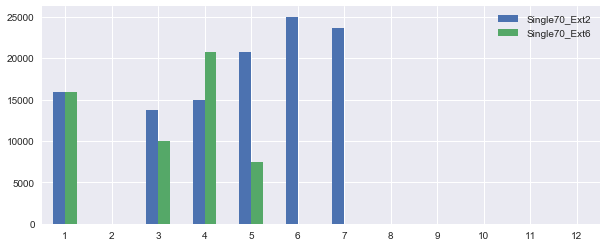

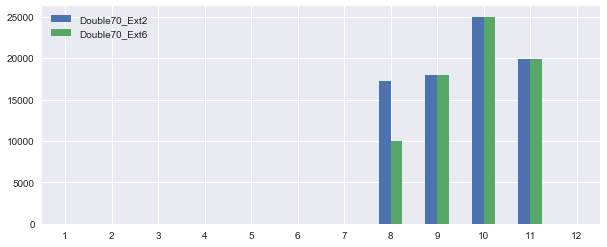

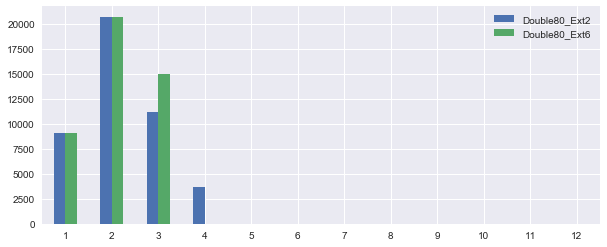

In [107]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,4))
ax = ext2['I'][['Single70']].join(ext6['I'][['Single70']], lsuffix='_Ext2', rsuffix='_Ext6').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
fig, ax = plt.subplots(figsize=(10,4))
ax = ext2['I'][['Double70']].join(ext6['I'][['Double70']], lsuffix='_Ext2', rsuffix='_Ext6').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
fig, ax = plt.subplots(figsize=(10,4))
ax = ext2['I'][['Double80']].join(ext6['I'][['Double80']], lsuffix='_Ext2', rsuffix='_Ext6').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
plt.show()

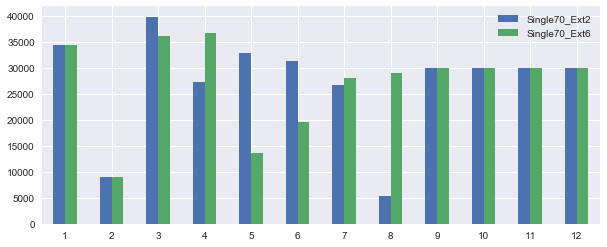

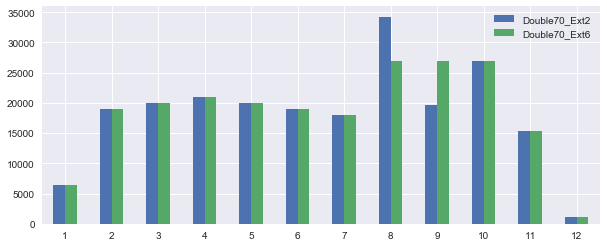

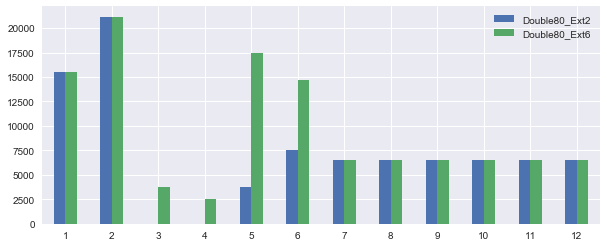

In [108]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,4))
ax = ext2['X'][['Single70']].join(ext6['X'][['Single70']], lsuffix='_Ext2', rsuffix='_Ext6').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
fig, ax = plt.subplots(figsize=(10,4))
ax = ext2['X'][['Double70']].join(ext6['X'][['Double70']], lsuffix='_Ext2', rsuffix='_Ext6').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
fig, ax = plt.subplots(figsize=(10,4))
ax = ext2['X'][['Double80']].join(ext6['X'][['Double80']], lsuffix='_Ext2', rsuffix='_Ext6').plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
plt.show()

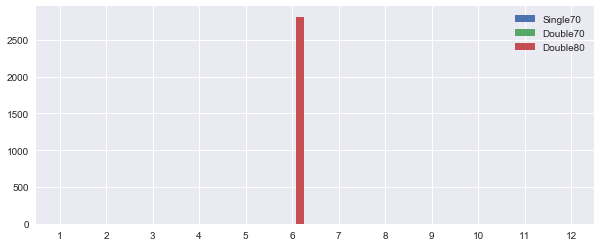

In [110]:
fig, ax = plt.subplots(figsize=(10,4))
ax = ext6['S'].plot.bar(rot=0, ax=ax)
ax.set_xticklabels(range(1,13))
plt.show()

In [115]:
ext2['W'].join(ext6['W'], lsuffix='_Ext2', rsuffix='_Ext6')

,Value_Ext2,Value_Ext6
0,90000.0,90000.0
1,90000.0,90000.0
2,90000.0,90000.0
3,90000.0,90000.0
4,90000.0,90000.0
5,90000.0,90000.0
6,100000.0,100000.0
7,100000.0,100000.0
8,100000.0,100000.0
9,100000.0,100000.0


In [117]:
ext2['O'].join(ext6['O'], lsuffix='_Ext2', rsuffix='_Ext6')

,Value_Ext2,Value_Ext6
0,22500.000000,22500.0
1,22500.000000,22500.0
2,18642.910448,22500.0
3,0.000000,22500.0
4,17247.089552,22500.0
5,22500.000000,22500.0
6,0.000000,2320.0
7,0.000000,23260.0
8,9330.000000,25000.0
9,25000.000000,25000.0


In [119]:
ext4['Objective'] - base['Objective']

662402.6990838647